In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import pickle
import os

In [2]:
def printArray(x):
    
    #find number with the most digits for formatting
    length = 0
    lnew = 0
    for i in range(0,len(x)):
        for j in range(0,len(x[0])):
            lnew = len(str(x[i][j]))
            if(lnew>length):
                length = lnew      
                
    #print the array
    for i in range(0,len(x[0])): #every column
        for k in range(0,len(x)*(length+3)): #print the line
            print("-", end='')
        print()
        print("| ", end='') #start the seperators
        for k in range(0,len(x)): #print the row
            print("{:^{}d}".format(x[k][i],length), "| ", end='')
        print()
    for k in range(0,len(x)*(length+3)):
            print("-", end='')
    print()
    
def printArray1D(x):
    length = 0
    lnew = 0
    for i in range(0,len(x)):
        lnew = len(str(x[i]))
        if(lnew>length):
            length = lnew 
            
    for k in range(0,len(x)*(length+3)): #print the line
        print("-", end='')
    print()
    print("| ", end='') #start the seperators
    for k in range(0,len(x)): #print the row
        print("{:^{}f}".format(x[k],length), "| ", end='')
    print()
    for k in range(0,len(x)*(length+3)):
            print("-", end='')
            
def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print ('Error: Creating directory. ' +  directory)

In [3]:
class Room:
    
    def __init__(self):
        self.reset()
        
    def clone(self):
        clone = Room()
        clone.rX=self.rX
        clone.rY=self.rY
        clone.over=self.over
        clone.rCarriesBox=self.rCarriesBox
        clone.c1Destroyed = self.c1Destroyed
        clone.visualize=self.visualize
        clone.trashCanLevel = self.trashCanLevel
        clone.moveSeq = self.moveSeq
        clone.depth = self.depth
        for i in range(0,5):
            for j in range(0,5):
                clone.env[i][j]=self.env[i][j]
                
        return clone
            
    
    def reset(self):
        self.rX = 3
        self.rY = 1
        self.over = False
        self.rCarriesBox = False
        self.c1Destroyed = False
        self.visualize = False
        self.trashCanLevel = 0
        self.moveSeq = ""
        self.totalReward = 0
        self.depth = 0
        self.env =  np.array([[0,-100,-100,-100,-100],[-100,0,50,0,-100],[-100,0,0,50,-100],[-100,100,50,0,-100],[-100,-100,-100,10,-100]])
       
    
    def step(self, move):
        #move is int 0-7
        
        #update moveSeq and depth
        self.moveSeq = self.moveSeq + " "+str(move)
        self.depth += 1
        
        #first, move left right up down + automatically pick up box / get turned off / destroy camera
        if(move==0 or move==4):
            #go left
            if(self.rX-1>=1):
                #three cases, dropped a box, is carrying a box, has no box
                if(self.env[self.rX-1][self.rY]==0):
                    #no box, just go there
                    if(self.env[self.rX][self.rY] == 150 and not(self.rCarriesBox)):
                        #leaves the box behind
                        self.env[self.rX][self.rY] = 50
                        self.env[self.rX-1][self.rY] = 100
                    else:
                        #either carries box with it or doesn't have a box
                        robot = self.env[self.rX][self.rY]
                        self.env[self.rX][self.rY] = 0
                        self.env[self.rX-1][self.rY] = robot
                        
                    self.rX-=1
                else:
                    #there is a box on the field where the robot wants to move
                    if(self.env[self.rX][self.rY] == 150 and not(self.rCarriesBox)):
                        #leaves the first box behind
                        self.env[self.rX][self.rY] = 50
                    else:
                        #either carries box with it or doesn't have a box
                        self.env[self.rX][self.rY] = 0
                        
                    self.env[self.rX-1][self.rY] = 150
                    self.rX-=1
                    if(not(self.rCarriesBox)):
                        #does not have a box and picks it up
                        #otherwise the robot accidentally destroys the other box
                        self.rCarriesBox = True
                if(self.visualize):
                    print("Moved left")
            else:
                #gets turned off before bumping into the wall
                self.over = True
            
        elif(move==1 or move==5):
            #go right
            if(self.rX+1<=3):
                if(self.env[self.rX+1][self.rY]==0):
                    #no box, just go there
                    if(self.env[self.rX][self.rY] == 150 and not(self.rCarriesBox)):
                        #leaves the box behind
                        self.env[self.rX][self.rY] = 50
                        self.env[self.rX+1][self.rY] = 100
                    else:
                        #either carries box with it or doesn't have a box
                        robot = self.env[self.rX][self.rY]
                        self.env[self.rX][self.rY] = 0
                        self.env[self.rX+1][self.rY] = robot
                    
                    self.rX+=1
                else:
                    #there is a box on the field where the robot wants to move
                    if(self.env[self.rX][self.rY] == 150 and not(self.rCarriesBox)):
                        #leaves the box behind
                        self.env[self.rX][self.rY] = 50
                    else:
                        #either carries box with it or doesn't have a box
                        self.env[self.rX][self.rY] = 0
                        
                    self.env[self.rX+1][self.rY] = 150
                    self.rX+=1
                    if(not(self.rCarriesBox)):
                        #does not have a box and picks it up
                        #otherwise the robot accidentally destroys the other box
                        self.rCarriesBox = True
                if(self.visualize):
                    print("Moved right")
            else:
                if(self.rX==3 and self.rY==3):
                    if(not(self.c1Destroyed)):
                        #destroys camera at the bottom right
                        self.c1Destroyed = True
                        self.env[4][3]=-100
                        if(self.visualize):
                            print("Destroyed bottom right camera")
                    else:
                        #the camera is already destroyed and the robot gets turned off before bumping into the wall
                        self.over = True 
                else:
                    #gets turned off before bumping into the wall
                    self.over = True
            
        elif(move==2 or move==6):
            #go down
            if(self.rY+1<=3):
                if(self.env[self.rX][self.rY+1]==0):
                    #no box, just go there
                    if(self.env[self.rX][self.rY] == 150 and not(self.rCarriesBox)):
                        #leaves the box behind
                        self.env[self.rX][self.rY] = 50
                        self.env[self.rX][self.rY+1] = 100
                    else:
                        #either carries box with it or doesn't have a box
                        robot = self.env[self.rX][self.rY]
                        self.env[self.rX][self.rY] = 0
                        self.env[self.rX][self.rY+1] = robot
                        
                    self.rY+=1
                else:
                    #there is a box on the field where the robot wants to move
                    if(self.env[self.rX][self.rY] == 150 and not(self.rCarriesBox)):
                        #leaves the box behind
                        self.env[self.rX][self.rY] = 50
                    else:
                        #either carries box with it or doesn't have a box
                        self.env[self.rX][self.rY] = 0
                    self.env[self.rX][self.rY+1] = 150
                    self.rY+=1
                    if(not(self.rCarriesBox)):
                        #does not have a box and picks it up
                        #otherwise the robot accidentally destroys the other box
                        self.rCarriesBox = True
                if(self.visualize):
                    print("Moved down")
            else:
                #gets turned off before bumping into the wall
                self.over = True
        elif(move==3 or move==7):
            #go up
            if(self.rY-1>=1):
                if(self.env[self.rX][self.rY-1]==0):
                    #no box, just go there
                    if(self.env[self.rX][self.rY] == 150 and not(self.rCarriesBox)):
                        #leaves the box behind
                        self.env[self.rX][self.rY] = 50
                        self.env[self.rX][self.rY-1] = 100
                    else:
                        #either carries box with it or doesn't have a box
                        robot = self.env[self.rX][self.rY]
                        self.env[self.rX][self.rY] = 0
                        self.env[self.rX][self.rY-1] = robot
                    
                    self.rY-=1
                else:
                    #there is a box on the field where the robot wants to move
                    if(self.env[self.rX][self.rY] == 150 and not(self.rCarriesBox)):
                        #leaves the box behind
                        self.env[self.rX][self.rY] = 50
                    else:
                        #either carries box with it or doesn't have a box
                        self.env[self.rX][self.rY] = 0
                    self.env[self.rX][self.rY-1] = 150
                    self.rY-=1
                    if(not(self.rCarriesBox)):
                        #does not have a box and picks it up
                        #otherwise the robot accidentally destroys the other box
                        self.rCarriesBox = True
                if(self.visualize):
                    print("Moved up")
            else:
                #gets turned off before bumping into the wall
                self.over = True
        
        #The robot has run out of power
        if(self.depth>=15):
            self.over=True
        
       
        #Any box set on 1 3 gets put into the garbage can
        if(self.env[1][3]==50):
            self.env[1][3]=0
        
        #small negative reward for every move to incentivize efficiency
        reward = -0.01
        
        #drop box and automatically turn off the robot if the camera sees that the robot is trying to go above trash can capacity
        if(move>3):
            carriedBox = self.rCarriesBox
            self.rCarriesBox = False
            if(self.rX==1 and self.rY == 3 and self.env[1][3]==150 and carriedBox):
                #put garbage into can
                reward += 100
                turnedOffByC = False
                if( self.trashCanLevel>=1 and  not(self.c1Destroyed)):
                    #turned off by the camera system
                    reward-=100 #that one doesn't count
                    turnedOffByC = True
                    self.over = True
                if(not(self.over) or not(turnedOffByC)):
                    self.trashCanLevel += 1
        
        if self.rCarriesBox:
            self.env[0][0]=1
        else:
            self.env[0][0]=0
            
        self.totalReward += reward
        
        return reward
        
    
    def rndmGame(self):
        self.visualize = True
        reward = 0
        while(not(self.over)):
            #make move
            move = np.random.randint(0,7)
            reward += self.step(move)
            self.render()
            print("Total reward: "+str(reward))
        
    def playerGame(self):
        self.visualize = True
        reward = 0
        while(not(self.over)):
            #make move
            move = int(input(" enter move "))
            reward += self.step(move)
            self.render()
            print("Total reward: "+str(reward))
        
    
    def render(self):
        print("------------------------------------------")
        print("Robot at "+str(self.rX)+" "+str(self.rY))
        printArray(self.env)
        #Last reward, last action print
        print("Camera 1 active = "+str(not(self.c1Destroyed)))
        print("Trash can level = "+str(self.trashCanLevel))
        if(self.over):
            print("The game is over")
        else:
            print("We're still good")
        print("------------------------------------------")
            
     
    def visualizeEnv(self,howLong,store=False,envI = "Default",folderName=None):
        #create a bgr array using the env
        visenv = np.zeros((5,5,3), dtype=np.uint8)
        for i in range(5):
            for j in range(5):
                visenv[j][i] = self.d[self.env[i][j]]
        if self.env[0][0]==1:
            visenv[0][0] = (0,200,200)
        else:
            visenv[0][0] = (0,200,0)
        if self.env[1][3]==0:
            visenv[3][1] = (200,200,200)
        
        #resize
        venv2 = np.zeros((500,500,3), dtype=np.uint8)
        for i in range(500):
            for j in range(500):
                venv2[i][j] = visenv[i//100][j//100]
        
        #if the robot is carrying a box
        exist150 = False
        for i in range(5):
            for j in range(5):
                if(self.env[i][j]==150):
                    exist150 = True
        #draw the robot carrying the box
        if exist150:           
            for i in range(self.rX*100,self.rX*100+50):
                for j in range(self.rY*100,self.rY*100+50):
                    venv2[j][i] = (10, 70, 110)
        else:
            for i in range(self.rX*100,self.rX*100+50):
                for j in range(self.rY*100,self.rY*100+50):
                    venv2[j][i] = (150,150,150)
                    
        #show the image on screen
        img = Image.fromarray(venv2, 'RGB')
        cv2.imshow("Environment", np.array(img));
        
        #wait for key activity or specified time + store the image
        if howLong==0:
            cv2.waitKey();
            if store:
                self.storeVis(np.array(img),f"Environment{envI}",folderName)
            self.endVis()
        else:
            cv2.waitKey(howLong)
            if store:
                self.storeVis(np.array(img),f"Environment{envI}",folderName)
        
    def endVis(self):
        cv2.destroyAllWindows()
    
    #Using for colors
    d = {100: (160, 160, 90),  
     150: (160, 160, 90),
     50: (10, 70, 110), 
     10: (0, 0, 255),
     1: (0, 0, 100),
    -100: (50, 50, 50),
     0: (250, 250, 250)}
    
    def visualizeMoveSeq(self,moveSeq,mi=-1,store=False,name="",folderName=None):
        if mi == -1:
            #go through all moves
            moveStrArr = moveSeq.split(' ')
            self.visualizeEnv(600,store,name+"0",folderName)
            for i in range(1,len(moveStrArr)):
                self.step(int(moveStrArr[i]))
                self.visualizeEnv(600,store,name+f"{i}",folderName)
                if self.over:
                    self.endVis()
                    break
            self.endVis()
        else:
            #only visualize one env state
            moveStrArr = moveSeq.split(' ')
            for i in range(1,mi+1):
                self.step(int(moveStrArr[i]))
                if self.over:
                    print("Sorry already over")
                    break
            if not self.over:
                self.visualizeEnv(0,store,name,folderName)
            self.endVis()
    
    #change directory for use on other pc
    def storeVis(self,pic,name,folderName=None):
        if folderName==None:
            cv2.imwrite(f'C:/Users/Nico/Desktop/Python/Images/img{name}.png',pic)
        else:
            createFolder(f"C:/Users/Nico/Desktop/Python/Images/{folderName}")
            cv2.imwrite(f'C:/Users/Nico/Desktop/Python/Images/{folderName}/img{name}.png',pic)

In [4]:
def humanUtility(moveSeq):
    r = Room()
    moveStrArr = moveSeq.split(' ')
    for i in range(1,len(moveStrArr)):
        r.step(int(moveStrArr[i]))
        if r.over:
            break
    if r.trashCanLevel ==1:
        return 100
    elif r.trashCanLevel ==0:
        return -10
    elif r.trashCanLevel >1:
        return -1000

In [5]:
class QTable:
    
    def __init__(self,rndm=False, new=True):
        self.rndm=rndm
        self.newQTable()
    
    def newQTable(self):
        
        self.tbl = {}
        
        
        #initialize queue for search
        q = []
        startNode = Room()
        q.append(startNode)
        
        
        #init qTable with start Node
        if(not self.rndm):
            self.tbl[startNode.env.tostring()] = np.array([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0])
        else:
            self.tbl[startNode.env.tostring()] = np.random.uniform(low=-1,high=2,size=8)
 
        #exhaustive search for getting all possible states
        while(len(q)>0):
            toExpand = q.pop(0)
            for move in range(0,8):
                c= toExpand.clone()
                c.step(move)
                #not yet expanded
                if not(c.env.tostring() in self.tbl): 
                    if(not self.rndm):
                        self.tbl[c.env.tostring()] =  np.array([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]) 
                    else:
                        self.tbl[c.env.tostring()] =  np.random.uniform(low=-1,high=2,size=8) 
                    if not(c.over):
                        q.append(c)
                        
    def printTable(self,n):
        i = 0
        for key in self.tbl.keys():
            i+=1
            print("---------")
            printArray(np.lib.stride_tricks.as_strided(np.frombuffer(key,dtype=int), (5,5), np.array([[0,-100,-100,-100,-100],[100,0,0,0,-100],[100,50,0,50,100],[-100,100,50,0,-100],[-100,-100,-100,10,-100]]).strides))
            printArray1D(self.tbl[key])
            print("---------")
            if i>n:
                break
                        
    def updateQ(self,env,action,q):
        self.tbl[env.tostring()][action] = q
        
    def getQValues(self,env):
        return self.tbl[env.tostring()]

    def getGreedyAction(self,env):
        return np.argmax(self.getQValues(env))
    
    def getGreedyActionQ(self,env):
        return np.max(self.getQValues(env))

In [6]:
class AgentQ:
    
    DISCOUNT = 0.9
    SAVE_EVERY = 1000

    
    def __init__(self,nEp, epsilon, lr, qt=None , resets=0):
        
        if qt==None:
            self.qt = QTable(True)
        else:
            self.qt = qt
            
        self.nEp = nEp
        self.lr = lr
        self.resets = resets
        self.epsilon = epsilon
        self.ogepsilon = epsilon
        self.offset=0
        self.startEpDecay = (nEp)//3
        self.endEpDecay = (nEp*9)//10
        self.epdecay = self.epsilon / (self.endEpDecay - self.startEpDecay)
        self.ep_rewards = []
        self.ep_sequences = [] 
        self.tbls = []
        self.mc = 0
        self.oc = 0
        self.aggr_ep_rewards = {'ep':[],'avg':[],'min':[],'max':[],'maxSeq':[]}
        self.r = Room()
        
    def reset(self):
        self.offset+=self.nEp
        self.epsilon = self.ogepsilon
        self.startEpDecay += self.offset
        self.endEpDecay += self.offset
        self.reset-=1
        self.train()
        
        
    def train(self):
        for ep in range(self.nEp):
            if(ep%(self.nEp//10)==0):
                print(str(ep)+" made it counter = "+str(self.mc)+" optimal counter = "+str(self.oc))
            
            self.r.reset()
           
            while not(self.r.over):
                #save the old env
                env = self.r.env.copy()

                #choose an action, either random or greedy
                rndm = np.random.random()
                if (rndm >= self.epsilon):
                    action = self.nextAction(env)
                else:
                    action = np.random.randint(0,8)

                #take the action
                reward = self.r.step(action)

                env_ = self.r.env

                #update table
                if not self.r.over:
                    max_future_q = self.qt.getGreedyActionQ(env_)
                    current_q = self.qt.getQValues(env)[action]
                    #Bellmann equation
                    newq = (1-self.lr) * current_q + self.lr * ( reward + self.DISCOUNT * max_future_q) 
                    self.qt.updateQ(env,action,newq)
                    
                else:
                    #update q to be the reward + 0 for actions leading to terminal states
                    self.qt.updateQ(env,action,reward)
                    
                    #keeping track of good runs
                    if self.r.totalReward >0:
                        self.mc += 1
                    if self.r.totalReward >= 284:
                        self.oc+=1
                    
                    
                #epsilon decay
                if (self.endEpDecay > ep) and (ep > self.startEpDecay) and self.r.over:
                    self.epsilon-=self.epdecay
                elif (self.endEpDecay < ep) and self.r.over:
                    #just in case there was a rounding error
                    self.epsilon = 0.0
                    
                
                
            self.ep_rewards.append(self.r.totalReward)
            self.ep_sequences.append(self.r.moveSeq)

            if not ep % self.SAVE_EVERY:
                average_reward = sum(self.ep_rewards[-self.SAVE_EVERY:])/len(self.ep_rewards[-self.SAVE_EVERY:])
                self.aggr_ep_rewards['ep'].append(ep+self.offset)
                self.aggr_ep_rewards['avg'].append(average_reward)
                self.aggr_ep_rewards['min'].append(min(self.ep_rewards[-self.SAVE_EVERY:]))
                self.aggr_ep_rewards['max'].append(max(self.ep_rewards[-self.SAVE_EVERY:]))
                self.aggr_ep_rewards['maxSeq'].append(self.ep_sequences[-self.SAVE_EVERY:][self.ep_rewards[-self.SAVE_EVERY:].index(max(self.ep_rewards[-self.SAVE_EVERY:]))])

            #optinal plotting every 500000 eps
            #if not ep % 50000 and not ep==0:
                #self.plot()

            #if good run then stop
            if (self.aggr_ep_rewards['avg'])[-1:][0]>240 and self.r.totalReward > 240:
                break
            
        if(self.resets>0):
            self.reset()
            
            
    def printTable(self,n):
        self.qt.printTable(n)
    
    def plot(self):
        plt.plot(self.aggr_ep_rewards['ep'],self.aggr_ep_rewards['avg'],label='avg')
        plt.plot(self.aggr_ep_rewards['ep'],self.aggr_ep_rewards['max'],label='max')
        plt.legend(loc=4)
        plt.show()
        
    def play(self): 
        self.r.reset()
        self.r.visualize= True
        self.r.render()
        while not self.r.over:
            self.r.step(self.nextAction(self.r.env))
            self.r.render()
        print("Total reward "+str(self.r.totalReward))
        
    def getMoveSeq(self):
        self.r.reset()
        while not self.r.over:
            self.r.step(self.nextAction(self.r.env))
        return self.r.moveSeq
        
    def nextAction(self,env):
        return self.qt.getGreedyAction(env)
    
    def store(self,location):
        pickle.dump(self, open(location,"wb"))
    
    def restoreTable(self,location):
        self.qt = pickle.load(open(location,"rb")).qt
        
    

0
0 made it counter = 0 optimal counter = 0
10000 made it counter = 8906 optimal counter = 14
20000 made it counter = 17839 optimal counter = 76
30000 made it counter = 26260 optimal counter = 81
40000 made it counter = 35505 optimal counter = 84
50000 made it counter = 44385 optimal counter = 3383


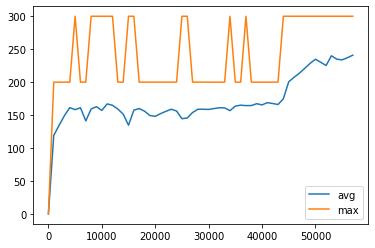

1
0 made it counter = 0 optimal counter = 0
10000 made it counter = 8354 optimal counter = 2316
20000 made it counter = 17246 optimal counter = 5526
30000 made it counter = 26020 optimal counter = 9141
40000 made it counter = 34904 optimal counter = 12613


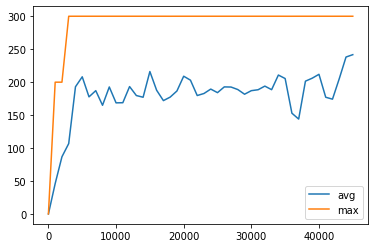

2
0 made it counter = 0 optimal counter = 0
10000 made it counter = 8348 optimal counter = 0
20000 made it counter = 17035 optimal counter = 0
30000 made it counter = 25861 optimal counter = 2
40000 made it counter = 34737 optimal counter = 154
50000 made it counter = 43844 optimal counter = 154
60000 made it counter = 53220 optimal counter = 154
70000 made it counter = 62756 optimal counter = 154
80000 made it counter = 72496 optimal counter = 154
90000 made it counter = 82423 optimal counter = 154


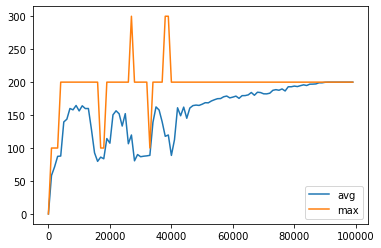

3
0 made it counter = 0 optimal counter = 0
10000 made it counter = 8682 optimal counter = 0
20000 made it counter = 17803 optimal counter = 0
30000 made it counter = 26819 optimal counter = 0
40000 made it counter = 35715 optimal counter = 0
50000 made it counter = 44995 optimal counter = 0
60000 made it counter = 53997 optimal counter = 0
70000 made it counter = 63300 optimal counter = 0
80000 made it counter = 72881 optimal counter = 0
90000 made it counter = 82743 optimal counter = 0


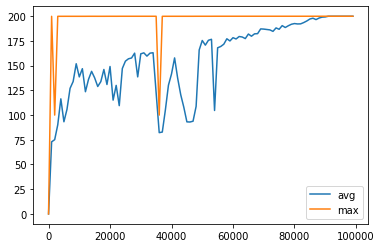

4
0 made it counter = 0 optimal counter = 0
10000 made it counter = 8712 optimal counter = 73
20000 made it counter = 17418 optimal counter = 3829
30000 made it counter = 25946 optimal counter = 4542
40000 made it counter = 34573 optimal counter = 4544
50000 made it counter = 43455 optimal counter = 4544
60000 made it counter = 52621 optimal counter = 4544
70000 made it counter = 61995 optimal counter = 4545
80000 made it counter = 71654 optimal counter = 4545
90000 made it counter = 81533 optimal counter = 4545


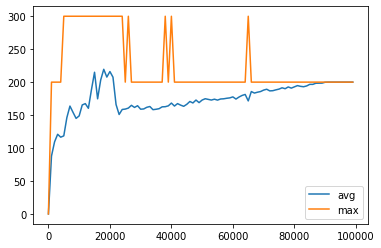

5
0 made it counter = 0 optimal counter = 0
10000 made it counter = 8489 optimal counter = 0
20000 made it counter = 17437 optimal counter = 0
30000 made it counter = 26134 optimal counter = 0
40000 made it counter = 35126 optimal counter = 0
50000 made it counter = 44158 optimal counter = 2
60000 made it counter = 53437 optimal counter = 2
70000 made it counter = 63122 optimal counter = 2
80000 made it counter = 72942 optimal counter = 24
90000 made it counter = 82867 optimal counter = 39


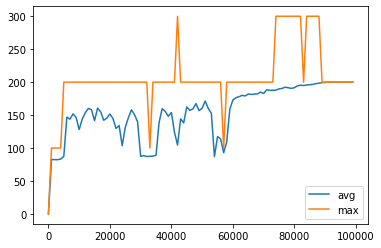

6
0 made it counter = 0 optimal counter = 0
10000 made it counter = 8773 optimal counter = 0
20000 made it counter = 17898 optimal counter = 0
30000 made it counter = 26880 optimal counter = 0
40000 made it counter = 35831 optimal counter = 988
50000 made it counter = 44854 optimal counter = 6366
60000 made it counter = 54127 optimal counter = 6366
70000 made it counter = 63744 optimal counter = 6640
80000 made it counter = 73504 optimal counter = 6909
90000 made it counter = 83436 optimal counter = 6909


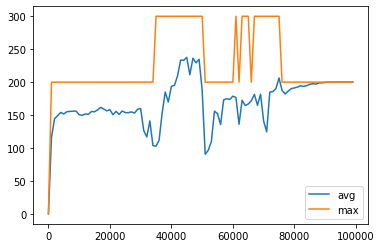

7
0 made it counter = 0 optimal counter = 0
10000 made it counter = 8785 optimal counter = 0
20000 made it counter = 17895 optimal counter = 490
30000 made it counter = 27039 optimal counter = 530
40000 made it counter = 35603 optimal counter = 2376
50000 made it counter = 44391 optimal counter = 5029
60000 made it counter = 53513 optimal counter = 5079


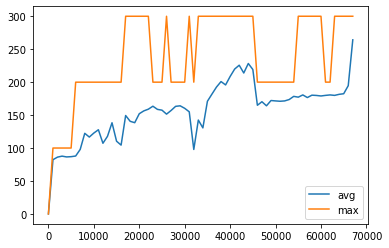

8
0 made it counter = 0 optimal counter = 0
10000 made it counter = 8230 optimal counter = 0
20000 made it counter = 17082 optimal counter = 2
30000 made it counter = 26152 optimal counter = 9
40000 made it counter = 35021 optimal counter = 21
50000 made it counter = 43752 optimal counter = 2811
60000 made it counter = 52762 optimal counter = 8088


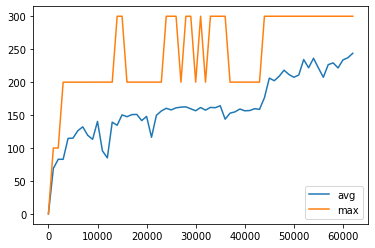

9
0 made it counter = 0 optimal counter = 0
10000 made it counter = 8668 optimal counter = 0
20000 made it counter = 17774 optimal counter = 29
30000 made it counter = 26924 optimal counter = 205
40000 made it counter = 36129 optimal counter = 3347
50000 made it counter = 45246 optimal counter = 6010
60000 made it counter = 54377 optimal counter = 6010
70000 made it counter = 63513 optimal counter = 6025
80000 made it counter = 73097 optimal counter = 6044
90000 made it counter = 82984 optimal counter = 6048


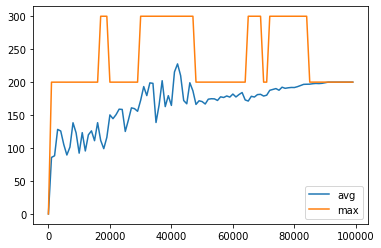

10
0 made it counter = 0 optimal counter = 0
10000 made it counter = 8968 optimal counter = 0
20000 made it counter = 17915 optimal counter = 0
30000 made it counter = 27095 optimal counter = 0
40000 made it counter = 36202 optimal counter = 0
50000 made it counter = 45493 optimal counter = 1
60000 made it counter = 54968 optimal counter = 1
70000 made it counter = 64486 optimal counter = 1
80000 made it counter = 74234 optimal counter = 1
90000 made it counter = 84163 optimal counter = 1


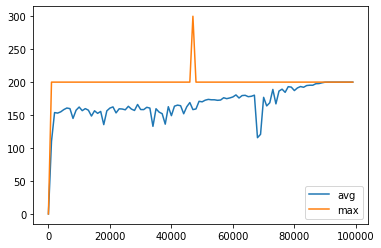

11
0 made it counter = 0 optimal counter = 0
10000 made it counter = 8413 optimal counter = 0
20000 made it counter = 17213 optimal counter = 1224
30000 made it counter = 26205 optimal counter = 1850
40000 made it counter = 35358 optimal counter = 2225
50000 made it counter = 44681 optimal counter = 2225
60000 made it counter = 54150 optimal counter = 2695
70000 made it counter = 63836 optimal counter = 2695
80000 made it counter = 73640 optimal counter = 2695
90000 made it counter = 83557 optimal counter = 2695


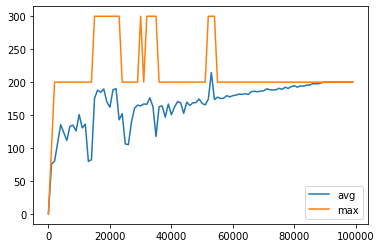

12
0 made it counter = 0 optimal counter = 0
10000 made it counter = 8585 optimal counter = 1169
20000 made it counter = 17190 optimal counter = 1223
30000 made it counter = 25705 optimal counter = 1224
40000 made it counter = 34441 optimal counter = 1322
50000 made it counter = 43309 optimal counter = 2555
60000 made it counter = 52483 optimal counter = 3599
70000 made it counter = 61898 optimal counter = 3599
80000 made it counter = 71560 optimal counter = 3599
90000 made it counter = 81455 optimal counter = 3599


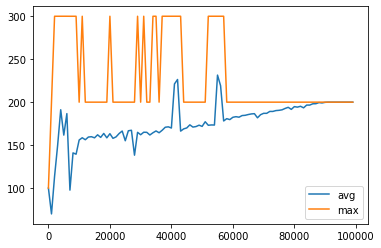

13
0 made it counter = 0 optimal counter = 0
10000 made it counter = 8514 optimal counter = 4088
20000 made it counter = 17598 optimal counter = 9236
30000 made it counter = 26577 optimal counter = 13731
40000 made it counter = 35535 optimal counter = 18600
50000 made it counter = 44702 optimal counter = 23509


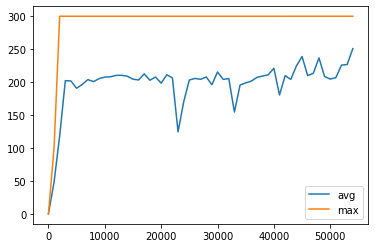

14
0 made it counter = 0 optimal counter = 0
10000 made it counter = 8144 optimal counter = 0
20000 made it counter = 16887 optimal counter = 0
30000 made it counter = 25869 optimal counter = 0
40000 made it counter = 35005 optimal counter = 0
50000 made it counter = 44332 optimal counter = 0
60000 made it counter = 53797 optimal counter = 0
70000 made it counter = 63336 optimal counter = 0
80000 made it counter = 73101 optimal counter = 0
90000 made it counter = 83022 optimal counter = 0


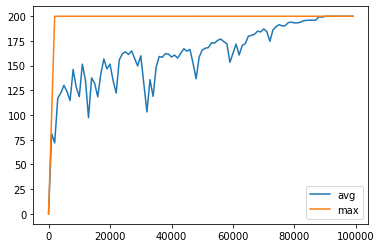

15
0 made it counter = 0 optimal counter = 0
10000 made it counter = 8862 optimal counter = 976
20000 made it counter = 18051 optimal counter = 1288
30000 made it counter = 27203 optimal counter = 1548
40000 made it counter = 36391 optimal counter = 1647
50000 made it counter = 45623 optimal counter = 1833
60000 made it counter = 55132 optimal counter = 1909


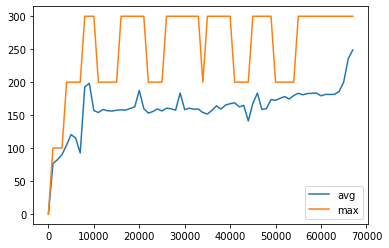

16
0 made it counter = 0 optimal counter = 0
10000 made it counter = 8582 optimal counter = 2498
20000 made it counter = 17430 optimal counter = 5528
30000 made it counter = 26263 optimal counter = 8381
40000 made it counter = 35033 optimal counter = 10579
50000 made it counter = 43550 optimal counter = 10866
60000 made it counter = 52904 optimal counter = 11986
70000 made it counter = 62447 optimal counter = 12012


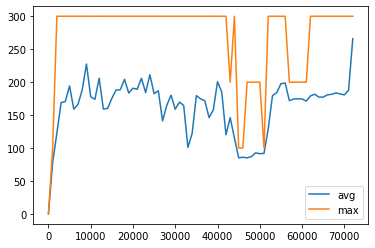

17
0 made it counter = 0 optimal counter = 0
10000 made it counter = 8688 optimal counter = 20
20000 made it counter = 17544 optimal counter = 265
30000 made it counter = 26160 optimal counter = 529
40000 made it counter = 35144 optimal counter = 544
50000 made it counter = 44324 optimal counter = 544
60000 made it counter = 53755 optimal counter = 544
70000 made it counter = 63290 optimal counter = 747
80000 made it counter = 72887 optimal counter = 747
90000 made it counter = 82842 optimal counter = 747


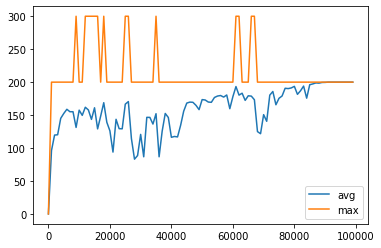

18
0 made it counter = 0 optimal counter = 0
10000 made it counter = 8496 optimal counter = 0
20000 made it counter = 17434 optimal counter = 0
30000 made it counter = 26274 optimal counter = 0
40000 made it counter = 35330 optimal counter = 0
50000 made it counter = 44582 optimal counter = 349
60000 made it counter = 54016 optimal counter = 400


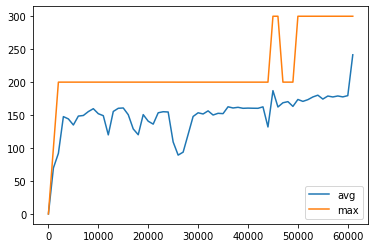

19
0 made it counter = 0 optimal counter = 0
10000 made it counter = 7725 optimal counter = 0
20000 made it counter = 16648 optimal counter = 206
30000 made it counter = 25596 optimal counter = 1331
40000 made it counter = 34639 optimal counter = 2570
50000 made it counter = 43449 optimal counter = 3049
60000 made it counter = 52509 optimal counter = 3049
70000 made it counter = 61874 optimal counter = 3049
80000 made it counter = 71458 optimal counter = 3049
90000 made it counter = 81305 optimal counter = 3049


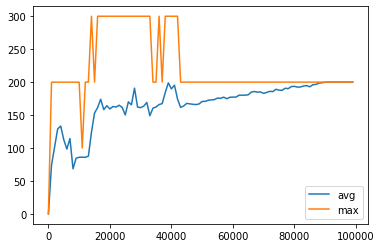

20
0 made it counter = 0 optimal counter = 0
10000 made it counter = 8035 optimal counter = 0
20000 made it counter = 17044 optimal counter = 170
30000 made it counter = 26003 optimal counter = 644
40000 made it counter = 35098 optimal counter = 644
50000 made it counter = 44426 optimal counter = 1920
60000 made it counter = 53916 optimal counter = 3536


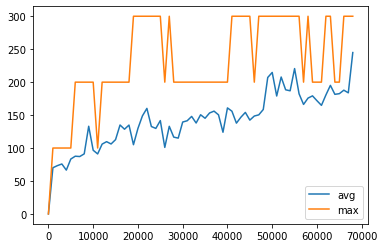

21
0 made it counter = 0 optimal counter = 0
10000 made it counter = 8569 optimal counter = 1343
20000 made it counter = 17556 optimal counter = 1891
30000 made it counter = 26399 optimal counter = 3292
40000 made it counter = 35068 optimal counter = 3292
50000 made it counter = 44007 optimal counter = 3293
60000 made it counter = 53162 optimal counter = 3293
70000 made it counter = 62578 optimal counter = 3293
80000 made it counter = 72243 optimal counter = 3293
90000 made it counter = 82131 optimal counter = 3293


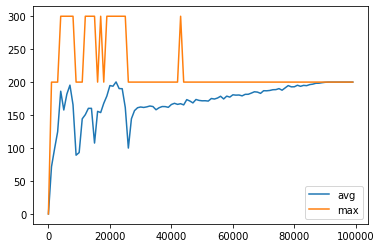

22
0 made it counter = 0 optimal counter = 0
10000 made it counter = 8680 optimal counter = 2
20000 made it counter = 17647 optimal counter = 253
30000 made it counter = 25916 optimal counter = 4236
40000 made it counter = 34556 optimal counter = 8854
50000 made it counter = 43436 optimal counter = 13951


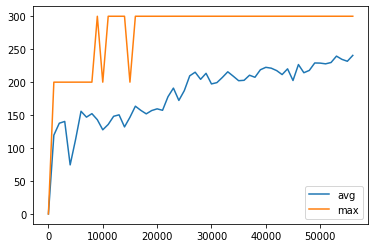

23
0 made it counter = 0 optimal counter = 0
10000 made it counter = 8476 optimal counter = 1
20000 made it counter = 17355 optimal counter = 2547
30000 made it counter = 25863 optimal counter = 6911
40000 made it counter = 34507 optimal counter = 12011


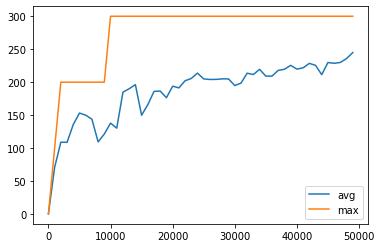

24
0 made it counter = 0 optimal counter = 0
10000 made it counter = 8740 optimal counter = 1947
20000 made it counter = 17808 optimal counter = 3659
30000 made it counter = 26798 optimal counter = 5096
40000 made it counter = 35910 optimal counter = 5313
50000 made it counter = 44809 optimal counter = 6991


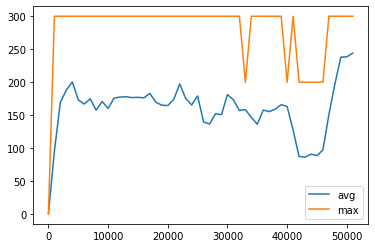

25
0 made it counter = 0 optimal counter = 0
10000 made it counter = 8663 optimal counter = 1358
20000 made it counter = 17218 optimal counter = 2371
30000 made it counter = 25985 optimal counter = 4342
40000 made it counter = 34989 optimal counter = 4346
50000 made it counter = 44068 optimal counter = 4544
60000 made it counter = 53497 optimal counter = 4544
70000 made it counter = 63099 optimal counter = 4544
80000 made it counter = 72869 optimal counter = 4544
90000 made it counter = 82778 optimal counter = 4544


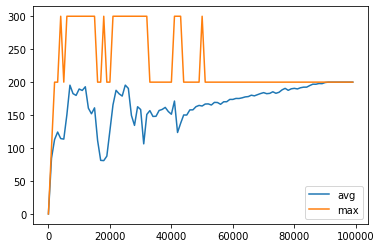

26
0 made it counter = 0 optimal counter = 0
10000 made it counter = 8853 optimal counter = 0
20000 made it counter = 17717 optimal counter = 1
30000 made it counter = 26433 optimal counter = 1
40000 made it counter = 35159 optimal counter = 2
50000 made it counter = 44113 optimal counter = 3
60000 made it counter = 53280 optimal counter = 33
70000 made it counter = 62675 optimal counter = 56
80000 made it counter = 72367 optimal counter = 76
90000 made it counter = 82249 optimal counter = 83


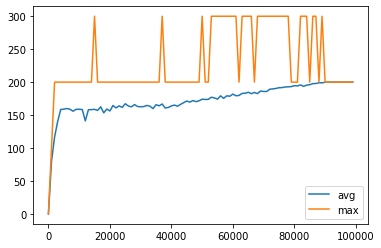

27
0 made it counter = 0 optimal counter = 0
10000 made it counter = 8662 optimal counter = 3337
20000 made it counter = 17372 optimal counter = 6217
30000 made it counter = 25851 optimal counter = 8404
40000 made it counter = 34363 optimal counter = 11447
50000 made it counter = 43291 optimal counter = 16597


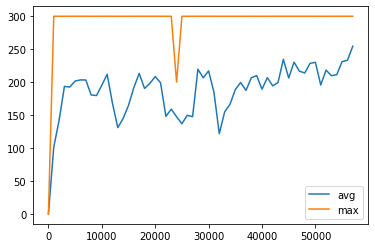

28
0 made it counter = 0 optimal counter = 0
10000 made it counter = 8137 optimal counter = 3910
20000 made it counter = 16509 optimal counter = 8148
30000 made it counter = 25102 optimal counter = 12538
40000 made it counter = 33720 optimal counter = 16172
50000 made it counter = 42532 optimal counter = 20919


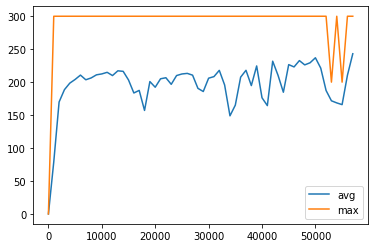

29
0 made it counter = 0 optimal counter = 0
10000 made it counter = 8466 optimal counter = 0
20000 made it counter = 17417 optimal counter = 1
30000 made it counter = 26153 optimal counter = 3110
40000 made it counter = 34726 optimal counter = 6275
50000 made it counter = 43586 optimal counter = 11237


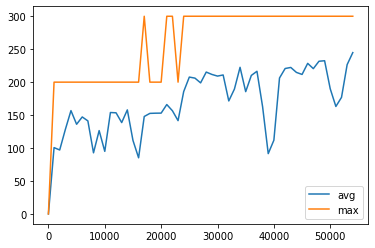

30
0 made it counter = 0 optimal counter = 0
10000 made it counter = 8364 optimal counter = 0
20000 made it counter = 16960 optimal counter = 0
30000 made it counter = 25469 optimal counter = 0
40000 made it counter = 34424 optimal counter = 11
50000 made it counter = 43132 optimal counter = 1199


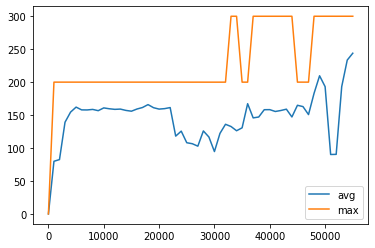

31
0 made it counter = 0 optimal counter = 0
10000 made it counter = 8804 optimal counter = 0
20000 made it counter = 17762 optimal counter = 1140
30000 made it counter = 26660 optimal counter = 1527
40000 made it counter = 35462 optimal counter = 3631
50000 made it counter = 44670 optimal counter = 5874
60000 made it counter = 54072 optimal counter = 8951


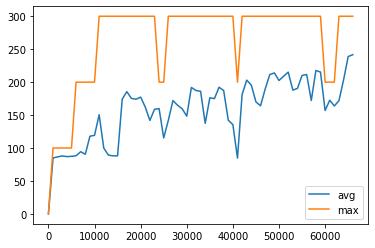

32
0 made it counter = 0 optimal counter = 0
10000 made it counter = 8105 optimal counter = 939
20000 made it counter = 16676 optimal counter = 3408
30000 made it counter = 25045 optimal counter = 6987
40000 made it counter = 33634 optimal counter = 10639
50000 made it counter = 42854 optimal counter = 15477
60000 made it counter = 52178 optimal counter = 21200


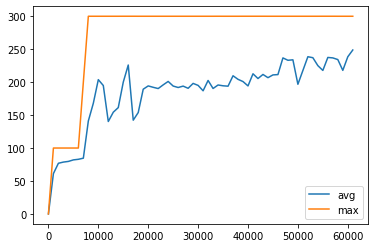

33
0 made it counter = 0 optimal counter = 0
10000 made it counter = 8902 optimal counter = 90
20000 made it counter = 17858 optimal counter = 2560
30000 made it counter = 26859 optimal counter = 5373
40000 made it counter = 35666 optimal counter = 8008
50000 made it counter = 44804 optimal counter = 11275
60000 made it counter = 54090 optimal counter = 14346


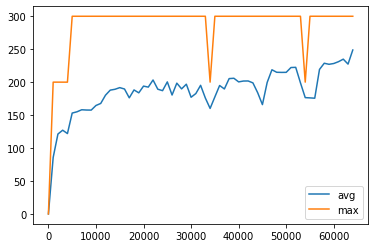

34
0 made it counter = 0 optimal counter = 0
10000 made it counter = 8311 optimal counter = 283
20000 made it counter = 17299 optimal counter = 1605
30000 made it counter = 26343 optimal counter = 1907
40000 made it counter = 35416 optimal counter = 2071
50000 made it counter = 44730 optimal counter = 2702
60000 made it counter = 54030 optimal counter = 2716
70000 made it counter = 63515 optimal counter = 2742
80000 made it counter = 73211 optimal counter = 2767
90000 made it counter = 83119 optimal counter = 2776


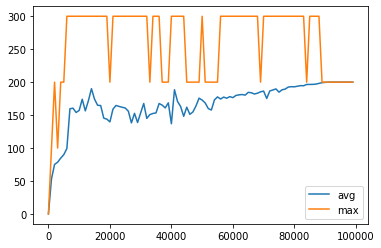

35
0 made it counter = 0 optimal counter = 0
10000 made it counter = 7565 optimal counter = 0
20000 made it counter = 16105 optimal counter = 0
30000 made it counter = 24188 optimal counter = 0
40000 made it counter = 32827 optimal counter = 0
50000 made it counter = 41781 optimal counter = 0
60000 made it counter = 50958 optimal counter = 0
70000 made it counter = 60371 optimal counter = 0
80000 made it counter = 70016 optimal counter = 0
90000 made it counter = 79893 optimal counter = 0


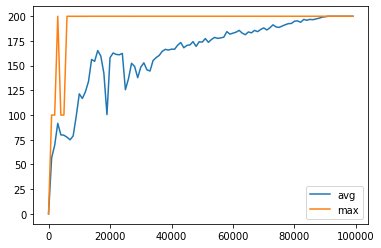

36
0 made it counter = 0 optimal counter = 0
10000 made it counter = 8535 optimal counter = 1
20000 made it counter = 17261 optimal counter = 1235
30000 made it counter = 25902 optimal counter = 5549
40000 made it counter = 34539 optimal counter = 10345
50000 made it counter = 43436 optimal counter = 15732


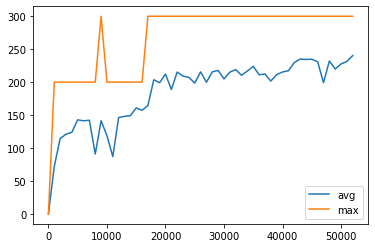

37
0 made it counter = 0 optimal counter = 0
10000 made it counter = 8434 optimal counter = 640
20000 made it counter = 17412 optimal counter = 5299
30000 made it counter = 26443 optimal counter = 10458
40000 made it counter = 35549 optimal counter = 15756
50000 made it counter = 44800 optimal counter = 19463


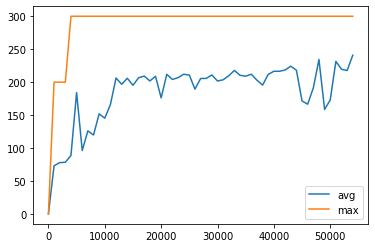

38
0 made it counter = 0 optimal counter = 0
10000 made it counter = 8142 optimal counter = 2326
20000 made it counter = 16805 optimal counter = 7223
30000 made it counter = 25464 optimal counter = 11492
40000 made it counter = 34234 optimal counter = 15845
50000 made it counter = 43227 optimal counter = 19966
60000 made it counter = 52596 optimal counter = 24781


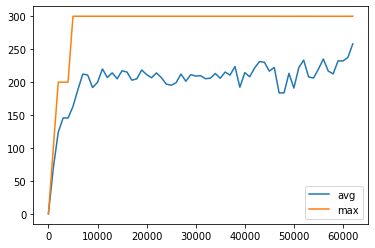

39
0 made it counter = 0 optimal counter = 0
10000 made it counter = 8540 optimal counter = 497
20000 made it counter = 17190 optimal counter = 2310
30000 made it counter = 25892 optimal counter = 2571
40000 made it counter = 34750 optimal counter = 4673
50000 made it counter = 43807 optimal counter = 8941


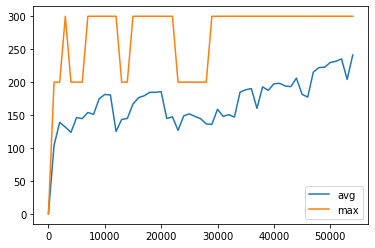

40
0 made it counter = 0 optimal counter = 0
10000 made it counter = 8673 optimal counter = 1241
20000 made it counter = 17729 optimal counter = 2663
30000 made it counter = 26668 optimal counter = 4128
40000 made it counter = 35592 optimal counter = 4321
50000 made it counter = 44584 optimal counter = 5230
60000 made it counter = 53840 optimal counter = 6686
70000 made it counter = 63380 optimal counter = 9746
80000 made it counter = 73127 optimal counter = 12044
90000 made it counter = 83045 optimal counter = 12044


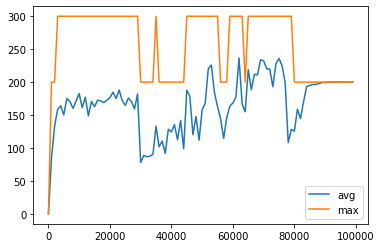

41
0 made it counter = 0 optimal counter = 0
10000 made it counter = 8308 optimal counter = 3542
20000 made it counter = 16830 optimal counter = 7542
30000 made it counter = 25389 optimal counter = 10993
40000 made it counter = 34111 optimal counter = 16139
50000 made it counter = 43003 optimal counter = 21752


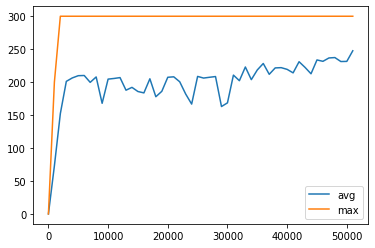

42
0 made it counter = 0 optimal counter = 0
10000 made it counter = 8598 optimal counter = 896
20000 made it counter = 17602 optimal counter = 2186
30000 made it counter = 26791 optimal counter = 2186
40000 made it counter = 35881 optimal counter = 3484
50000 made it counter = 44780 optimal counter = 3622


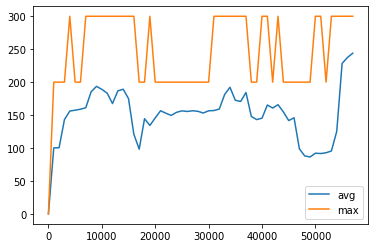

43
0 made it counter = 0 optimal counter = 0
10000 made it counter = 8371 optimal counter = 0
20000 made it counter = 17249 optimal counter = 19
30000 made it counter = 26343 optimal counter = 19
40000 made it counter = 35461 optimal counter = 2136
50000 made it counter = 44768 optimal counter = 4335
60000 made it counter = 54240 optimal counter = 7284
70000 made it counter = 63867 optimal counter = 11253


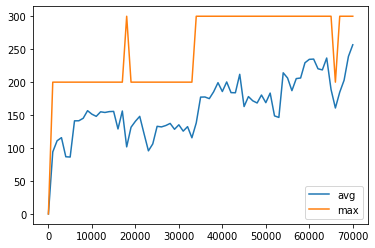

44
0 made it counter = 0 optimal counter = 0
10000 made it counter = 8675 optimal counter = 160
20000 made it counter = 17712 optimal counter = 2523
30000 made it counter = 26867 optimal counter = 4837
40000 made it counter = 36060 optimal counter = 6427
50000 made it counter = 45101 optimal counter = 8358
60000 made it counter = 54268 optimal counter = 8359
70000 made it counter = 63647 optimal counter = 8359
80000 made it counter = 73294 optimal counter = 8359
90000 made it counter = 83189 optimal counter = 8360


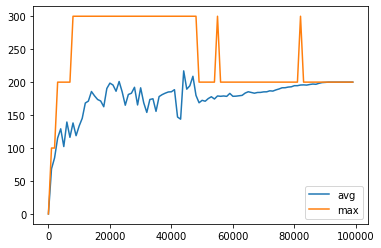

45
0 made it counter = 0 optimal counter = 0
10000 made it counter = 8509 optimal counter = 0
20000 made it counter = 17651 optimal counter = 2
30000 made it counter = 26789 optimal counter = 2
40000 made it counter = 35995 optimal counter = 2
50000 made it counter = 45321 optimal counter = 2
60000 made it counter = 54808 optimal counter = 2
70000 made it counter = 64434 optimal counter = 2
80000 made it counter = 74225 optimal counter = 2
90000 made it counter = 84155 optimal counter = 2


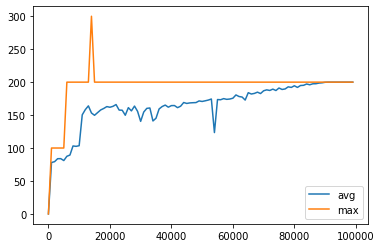

46
0 made it counter = 0 optimal counter = 0
10000 made it counter = 8719 optimal counter = 1318
20000 made it counter = 17488 optimal counter = 4289
30000 made it counter = 26326 optimal counter = 7122
40000 made it counter = 35447 optimal counter = 9603
50000 made it counter = 44757 optimal counter = 12006
60000 made it counter = 54243 optimal counter = 14293
70000 made it counter = 63888 optimal counter = 16025
80000 made it counter = 73663 optimal counter = 17204
90000 made it counter = 83601 optimal counter = 17774


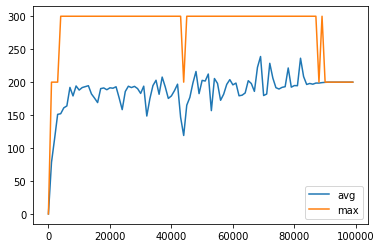

47
0 made it counter = 0 optimal counter = 0
10000 made it counter = 8906 optimal counter = 967
20000 made it counter = 17959 optimal counter = 3156
30000 made it counter = 26730 optimal counter = 7801
40000 made it counter = 35533 optimal counter = 9433
50000 made it counter = 44544 optimal counter = 11776
60000 made it counter = 53574 optimal counter = 11778
70000 made it counter = 62954 optimal counter = 11778
80000 made it counter = 72587 optimal counter = 11778
90000 made it counter = 82462 optimal counter = 11778


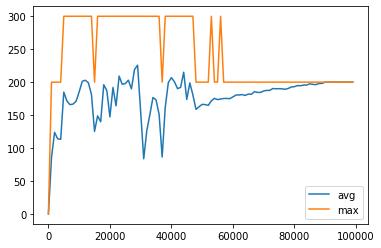

48
0 made it counter = 0 optimal counter = 0
10000 made it counter = 8539 optimal counter = 0
20000 made it counter = 17494 optimal counter = 0
30000 made it counter = 26408 optimal counter = 0
40000 made it counter = 35332 optimal counter = 0
50000 made it counter = 44513 optimal counter = 1
60000 made it counter = 53857 optimal counter = 1
70000 made it counter = 63340 optimal counter = 1
80000 made it counter = 72889 optimal counter = 1
90000 made it counter = 82753 optimal counter = 1


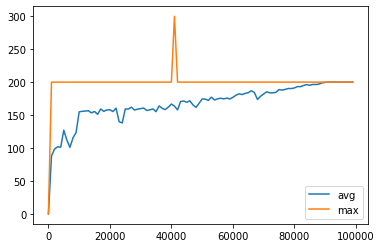

49
0 made it counter = 0 optimal counter = 0
10000 made it counter = 7919 optimal counter = 237
20000 made it counter = 16889 optimal counter = 274
30000 made it counter = 25866 optimal counter = 381
40000 made it counter = 35022 optimal counter = 446
50000 made it counter = 44307 optimal counter = 2373


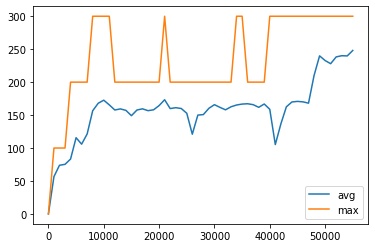

50
0 made it counter = 0 optimal counter = 0
10000 made it counter = 8782 optimal counter = 2031
20000 made it counter = 17635 optimal counter = 6060
30000 made it counter = 26447 optimal counter = 9272
40000 made it counter = 35179 optimal counter = 13417
50000 made it counter = 44039 optimal counter = 18247


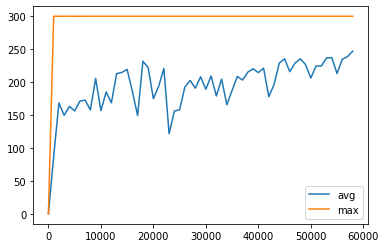

51
0 made it counter = 0 optimal counter = 0
10000 made it counter = 8583 optimal counter = 0
20000 made it counter = 17567 optimal counter = 0
30000 made it counter = 26469 optimal counter = 0
40000 made it counter = 35060 optimal counter = 1349


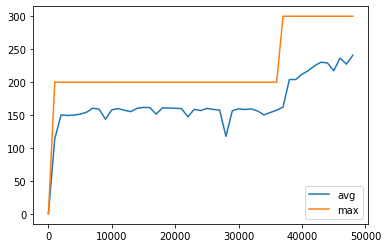

52
0 made it counter = 0 optimal counter = 0
10000 made it counter = 8843 optimal counter = 0
20000 made it counter = 17872 optimal counter = 0
30000 made it counter = 26659 optimal counter = 0
40000 made it counter = 35367 optimal counter = 1
50000 made it counter = 44294 optimal counter = 2370
60000 made it counter = 53475 optimal counter = 3045
70000 made it counter = 62812 optimal counter = 3045


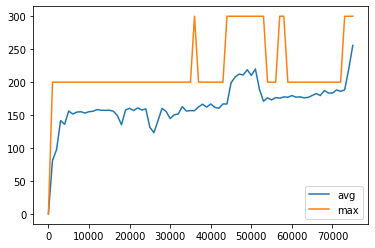

53
0 made it counter = 0 optimal counter = 0
10000 made it counter = 8510 optimal counter = 0
20000 made it counter = 16721 optimal counter = 0
30000 made it counter = 25730 optimal counter = 0
40000 made it counter = 34855 optimal counter = 0
50000 made it counter = 44051 optimal counter = 0
60000 made it counter = 53442 optimal counter = 0
70000 made it counter = 63077 optimal counter = 0
80000 made it counter = 72874 optimal counter = 0
90000 made it counter = 82796 optimal counter = 0


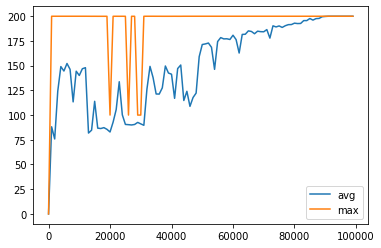

54
0 made it counter = 0 optimal counter = 0
10000 made it counter = 8470 optimal counter = 0
20000 made it counter = 17374 optimal counter = 1
30000 made it counter = 26462 optimal counter = 1
40000 made it counter = 35457 optimal counter = 1
50000 made it counter = 44693 optimal counter = 1
60000 made it counter = 54166 optimal counter = 1
70000 made it counter = 63789 optimal counter = 1
80000 made it counter = 73556 optimal counter = 1
90000 made it counter = 83491 optimal counter = 1


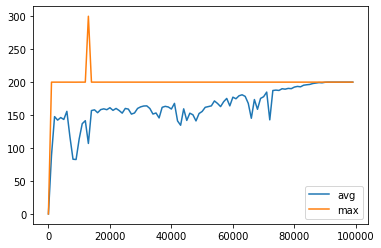

55
0 made it counter = 0 optimal counter = 0
10000 made it counter = 8815 optimal counter = 2239
20000 made it counter = 17829 optimal counter = 4001
30000 made it counter = 26640 optimal counter = 6077
40000 made it counter = 35436 optimal counter = 7209
50000 made it counter = 44315 optimal counter = 12109


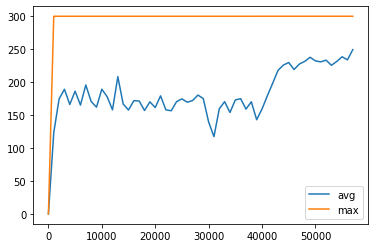

56
0 made it counter = 0 optimal counter = 0
10000 made it counter = 8681 optimal counter = 0
20000 made it counter = 17763 optimal counter = 0
30000 made it counter = 26478 optimal counter = 4129
40000 made it counter = 34967 optimal counter = 8154
50000 made it counter = 43628 optimal counter = 11072


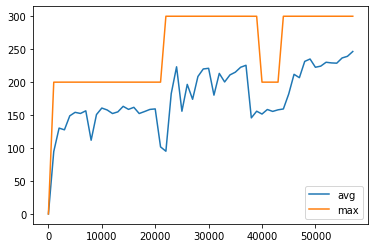

57
0 made it counter = 0 optimal counter = 0
10000 made it counter = 8550 optimal counter = 614
20000 made it counter = 17277 optimal counter = 2025
30000 made it counter = 26098 optimal counter = 5702
40000 made it counter = 34809 optimal counter = 10617
50000 made it counter = 43739 optimal counter = 14970


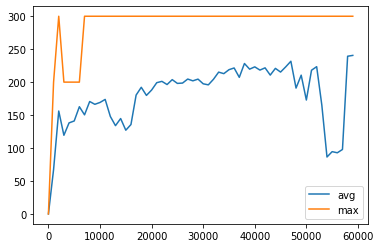

58
0 made it counter = 0 optimal counter = 0
10000 made it counter = 7747 optimal counter = 0
20000 made it counter = 15964 optimal counter = 0
30000 made it counter = 24826 optimal counter = 0
40000 made it counter = 33713 optimal counter = 76
50000 made it counter = 42635 optimal counter = 76
60000 made it counter = 51925 optimal counter = 76
70000 made it counter = 61442 optimal counter = 77
80000 made it counter = 71142 optimal counter = 77
90000 made it counter = 81050 optimal counter = 77


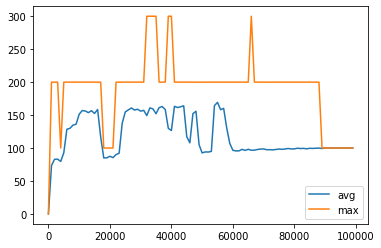

59
0 made it counter = 0 optimal counter = 0
10000 made it counter = 8251 optimal counter = 2
20000 made it counter = 17241 optimal counter = 24
30000 made it counter = 26060 optimal counter = 1793
40000 made it counter = 34311 optimal counter = 2264
50000 made it counter = 42961 optimal counter = 2264
60000 made it counter = 52159 optimal counter = 2264
70000 made it counter = 61730 optimal counter = 2264
80000 made it counter = 71517 optimal counter = 2264
90000 made it counter = 81421 optimal counter = 2264


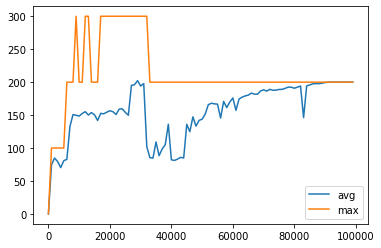

60
0 made it counter = 0 optimal counter = 0
10000 made it counter = 8442 optimal counter = 0
20000 made it counter = 17537 optimal counter = 0
30000 made it counter = 26258 optimal counter = 0
40000 made it counter = 35385 optimal counter = 113
50000 made it counter = 44720 optimal counter = 718
60000 made it counter = 54228 optimal counter = 1268
70000 made it counter = 63886 optimal counter = 1476


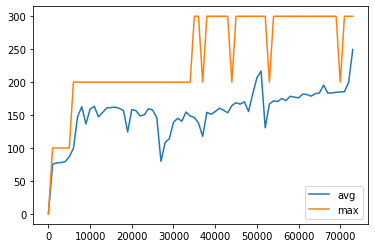

61
0 made it counter = 0 optimal counter = 0
10000 made it counter = 8804 optimal counter = 0
20000 made it counter = 17843 optimal counter = 0
30000 made it counter = 26283 optimal counter = 0
40000 made it counter = 35251 optimal counter = 112
50000 made it counter = 44571 optimal counter = 112
60000 made it counter = 54014 optimal counter = 112
70000 made it counter = 63703 optimal counter = 112
80000 made it counter = 73491 optimal counter = 112
90000 made it counter = 83414 optimal counter = 112


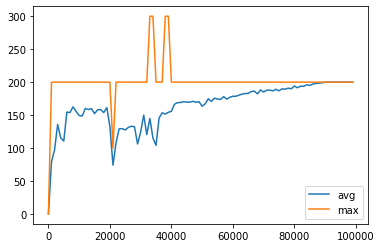

62
0 made it counter = 0 optimal counter = 0
10000 made it counter = 8675 optimal counter = 0
20000 made it counter = 17424 optimal counter = 0
30000 made it counter = 26225 optimal counter = 0
40000 made it counter = 34887 optimal counter = 0
50000 made it counter = 44157 optimal counter = 0
60000 made it counter = 53578 optimal counter = 0
70000 made it counter = 63215 optimal counter = 0
80000 made it counter = 72991 optimal counter = 0
90000 made it counter = 82925 optimal counter = 0


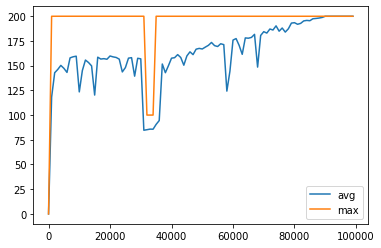

63
0 made it counter = 0 optimal counter = 0
10000 made it counter = 8202 optimal counter = 0
20000 made it counter = 16809 optimal counter = 1092
30000 made it counter = 25380 optimal counter = 4676
40000 made it counter = 33894 optimal counter = 8577
50000 made it counter = 42777 optimal counter = 13259


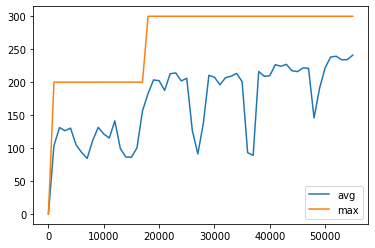

64
0 made it counter = 0 optimal counter = 0
10000 made it counter = 8371 optimal counter = 1245
20000 made it counter = 17352 optimal counter = 4046
30000 made it counter = 26416 optimal counter = 5689
40000 made it counter = 35413 optimal counter = 6359
50000 made it counter = 44454 optimal counter = 9806
60000 made it counter = 53635 optimal counter = 14302


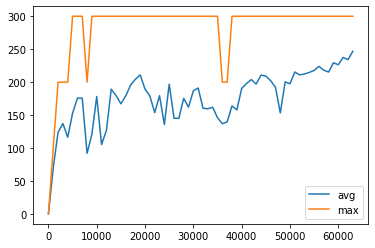

65
0 made it counter = 0 optimal counter = 0
10000 made it counter = 8502 optimal counter = 0
20000 made it counter = 16755 optimal counter = 2371
30000 made it counter = 25365 optimal counter = 4668
40000 made it counter = 34520 optimal counter = 5091
50000 made it counter = 43713 optimal counter = 5831
60000 made it counter = 53108 optimal counter = 6367
70000 made it counter = 62709 optimal counter = 6367
80000 made it counter = 72495 optimal counter = 6367
90000 made it counter = 82426 optimal counter = 6367


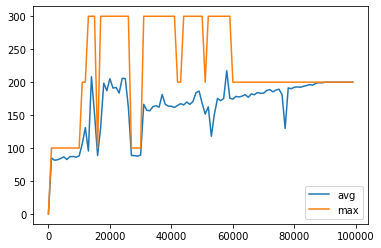

66
0 made it counter = 0 optimal counter = 0
10000 made it counter = 8303 optimal counter = 0
20000 made it counter = 17251 optimal counter = 329
30000 made it counter = 26334 optimal counter = 519
40000 made it counter = 35242 optimal counter = 792
50000 made it counter = 44532 optimal counter = 1142
60000 made it counter = 53927 optimal counter = 1175
70000 made it counter = 63536 optimal counter = 1198
80000 made it counter = 73339 optimal counter = 1198
90000 made it counter = 83278 optimal counter = 1198


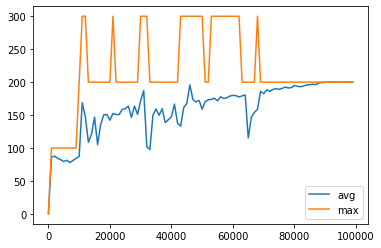

67
0 made it counter = 0 optimal counter = 0
10000 made it counter = 8726 optimal counter = 0
20000 made it counter = 17830 optimal counter = 0
30000 made it counter = 26835 optimal counter = 0
40000 made it counter = 36048 optimal counter = 0
50000 made it counter = 45255 optimal counter = 338
60000 made it counter = 54215 optimal counter = 342
70000 made it counter = 63835 optimal counter = 342
80000 made it counter = 73603 optimal counter = 342
90000 made it counter = 83539 optimal counter = 342


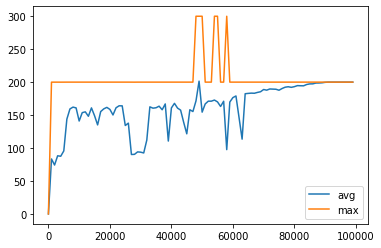

68
0 made it counter = 0 optimal counter = 0
10000 made it counter = 8692 optimal counter = 0
20000 made it counter = 17712 optimal counter = 0
30000 made it counter = 26609 optimal counter = 0
40000 made it counter = 35730 optimal counter = 0
50000 made it counter = 44758 optimal counter = 0
60000 made it counter = 53978 optimal counter = 0
70000 made it counter = 63610 optimal counter = 0
80000 made it counter = 73406 optimal counter = 0
90000 made it counter = 83343 optimal counter = 0


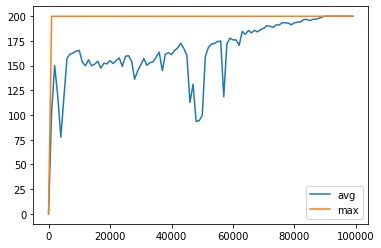

69
0 made it counter = 0 optimal counter = 0
10000 made it counter = 8163 optimal counter = 0
20000 made it counter = 16660 optimal counter = 726
30000 made it counter = 25724 optimal counter = 727
40000 made it counter = 34769 optimal counter = 729
50000 made it counter = 43605 optimal counter = 729
60000 made it counter = 52753 optimal counter = 729
70000 made it counter = 62136 optimal counter = 729
80000 made it counter = 71765 optimal counter = 729
90000 made it counter = 81649 optimal counter = 729


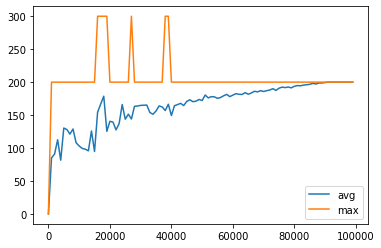

70
0 made it counter = 0 optimal counter = 0
10000 made it counter = 8706 optimal counter = 0
20000 made it counter = 17382 optimal counter = 1
30000 made it counter = 25859 optimal counter = 448
40000 made it counter = 34144 optimal counter = 452
50000 made it counter = 43044 optimal counter = 452
60000 made it counter = 52119 optimal counter = 452
70000 made it counter = 61599 optimal counter = 3719


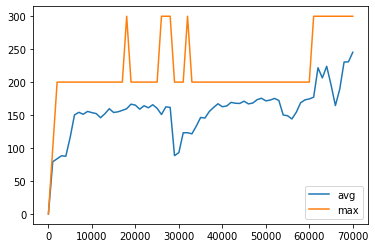

71
0 made it counter = 0 optimal counter = 0
10000 made it counter = 8029 optimal counter = 0
20000 made it counter = 15969 optimal counter = 0
30000 made it counter = 24114 optimal counter = 0
40000 made it counter = 32323 optimal counter = 0
50000 made it counter = 40855 optimal counter = 0
60000 made it counter = 49744 optimal counter = 0
70000 made it counter = 58886 optimal counter = 0
80000 made it counter = 68396 optimal counter = 0
90000 made it counter = 78231 optimal counter = 0


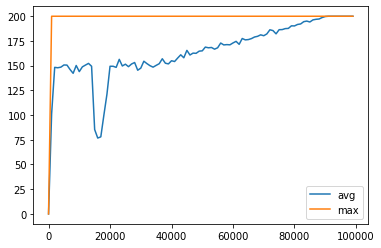

72
0 made it counter = 0 optimal counter = 0
10000 made it counter = 8446 optimal counter = 172
20000 made it counter = 17394 optimal counter = 2282
30000 made it counter = 25688 optimal counter = 5384
40000 made it counter = 34370 optimal counter = 10221
50000 made it counter = 43260 optimal counter = 15611


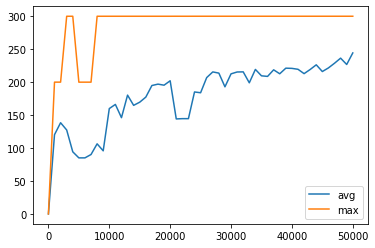

73
0 made it counter = 0 optimal counter = 0
10000 made it counter = 8511 optimal counter = 677
20000 made it counter = 17103 optimal counter = 2932
30000 made it counter = 25570 optimal counter = 5710
40000 made it counter = 34187 optimal counter = 9679
50000 made it counter = 43100 optimal counter = 15099


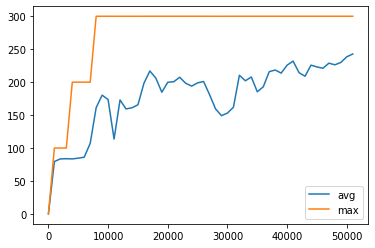

74
0 made it counter = 0 optimal counter = 0
10000 made it counter = 8674 optimal counter = 1254
20000 made it counter = 17394 optimal counter = 2439
30000 made it counter = 26383 optimal counter = 3678
40000 made it counter = 35489 optimal counter = 6566
50000 made it counter = 44763 optimal counter = 11458


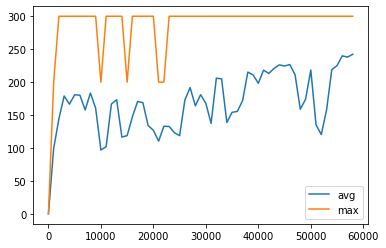

75
0 made it counter = 0 optimal counter = 0
10000 made it counter = 9062 optimal counter = 0
20000 made it counter = 17607 optimal counter = 0
30000 made it counter = 26408 optimal counter = 1051
40000 made it counter = 35561 optimal counter = 1208
50000 made it counter = 44912 optimal counter = 1221
60000 made it counter = 54431 optimal counter = 1222
70000 made it counter = 64021 optimal counter = 1224
80000 made it counter = 73832 optimal counter = 1224
90000 made it counter = 83767 optimal counter = 1224


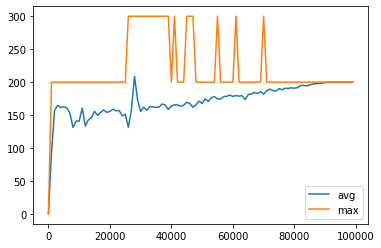

76
0 made it counter = 0 optimal counter = 0
10000 made it counter = 8500 optimal counter = 0
20000 made it counter = 17344 optimal counter = 15
30000 made it counter = 26217 optimal counter = 52
40000 made it counter = 34942 optimal counter = 91
50000 made it counter = 44006 optimal counter = 126
60000 made it counter = 53227 optimal counter = 128
70000 made it counter = 62626 optimal counter = 129
80000 made it counter = 72331 optimal counter = 154
90000 made it counter = 82257 optimal counter = 162


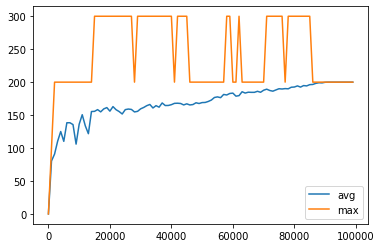

77
0 made it counter = 0 optimal counter = 0
10000 made it counter = 8719 optimal counter = 0
20000 made it counter = 17395 optimal counter = 1656
30000 made it counter = 26021 optimal counter = 5629
40000 made it counter = 34666 optimal counter = 10092
50000 made it counter = 43640 optimal counter = 14810


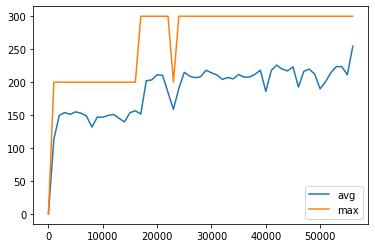

78
0 made it counter = 0 optimal counter = 0
10000 made it counter = 8256 optimal counter = 652
20000 made it counter = 16516 optimal counter = 1621
30000 made it counter = 24615 optimal counter = 2838
40000 made it counter = 33042 optimal counter = 4849
50000 made it counter = 41931 optimal counter = 4902
60000 made it counter = 51062 optimal counter = 4966
70000 made it counter = 60467 optimal counter = 5017
80000 made it counter = 70104 optimal counter = 5063
90000 made it counter = 79980 optimal counter = 5079


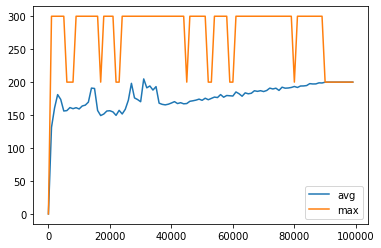

79
0 made it counter = 0 optimal counter = 0
10000 made it counter = 8847 optimal counter = 247
20000 made it counter = 17990 optimal counter = 1899
30000 made it counter = 27110 optimal counter = 5542
40000 made it counter = 35848 optimal counter = 10235
50000 made it counter = 44769 optimal counter = 12421
60000 made it counter = 53937 optimal counter = 12421
70000 made it counter = 63311 optimal counter = 12423
80000 made it counter = 72951 optimal counter = 12423
90000 made it counter = 82837 optimal counter = 12423


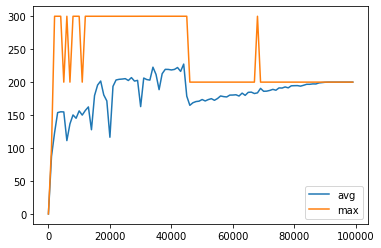

80
0 made it counter = 0 optimal counter = 0
10000 made it counter = 8834 optimal counter = 586
20000 made it counter = 17913 optimal counter = 1219
30000 made it counter = 26960 optimal counter = 1226
40000 made it counter = 36066 optimal counter = 1235
50000 made it counter = 45400 optimal counter = 2675
60000 made it counter = 54883 optimal counter = 3227
70000 made it counter = 64516 optimal counter = 3227
80000 made it counter = 74322 optimal counter = 3227
90000 made it counter = 84248 optimal counter = 3227


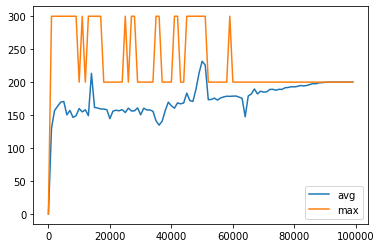

81
0 made it counter = 0 optimal counter = 0
10000 made it counter = 8694 optimal counter = 151
20000 made it counter = 17473 optimal counter = 634
30000 made it counter = 26051 optimal counter = 3287
40000 made it counter = 34360 optimal counter = 5586
50000 made it counter = 43236 optimal counter = 11104


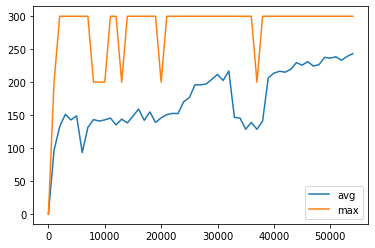

82
0 made it counter = 0 optimal counter = 0
10000 made it counter = 8040 optimal counter = 0
20000 made it counter = 16407 optimal counter = 0
30000 made it counter = 25152 optimal counter = 1
40000 made it counter = 33908 optimal counter = 4
50000 made it counter = 43185 optimal counter = 4
60000 made it counter = 52595 optimal counter = 4


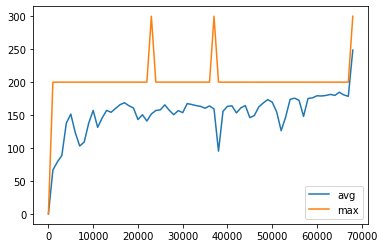

83
0 made it counter = 0 optimal counter = 0
10000 made it counter = 8567 optimal counter = 1494
20000 made it counter = 17146 optimal counter = 5857
30000 made it counter = 25629 optimal counter = 8891
40000 made it counter = 34292 optimal counter = 11093
50000 made it counter = 43152 optimal counter = 14392


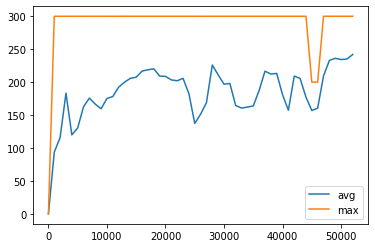

84
0 made it counter = 0 optimal counter = 0
10000 made it counter = 8821 optimal counter = 1895
20000 made it counter = 17735 optimal counter = 3982
30000 made it counter = 26387 optimal counter = 4885
40000 made it counter = 35158 optimal counter = 4885
50000 made it counter = 44147 optimal counter = 4887
60000 made it counter = 53303 optimal counter = 4926
70000 made it counter = 62767 optimal counter = 4966
80000 made it counter = 72428 optimal counter = 5017
90000 made it counter = 82324 optimal counter = 5031


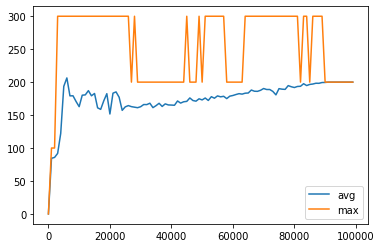

85
0 made it counter = 0 optimal counter = 0
10000 made it counter = 8930 optimal counter = 30
20000 made it counter = 17785 optimal counter = 30
30000 made it counter = 26484 optimal counter = 30
40000 made it counter = 35347 optimal counter = 33
50000 made it counter = 44692 optimal counter = 99
60000 made it counter = 54208 optimal counter = 135
70000 made it counter = 63867 optimal counter = 135
80000 made it counter = 73670 optimal counter = 165
90000 made it counter = 83596 optimal counter = 182


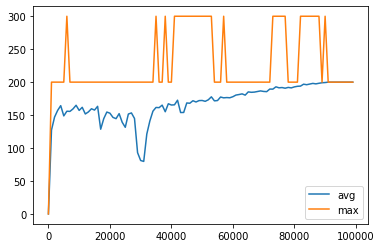

86
0 made it counter = 0 optimal counter = 0
10000 made it counter = 8514 optimal counter = 17
20000 made it counter = 17474 optimal counter = 17
30000 made it counter = 25982 optimal counter = 969
40000 made it counter = 34354 optimal counter = 5383
50000 made it counter = 43173 optimal counter = 11004


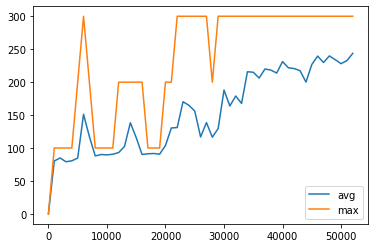

87
0 made it counter = 0 optimal counter = 0
10000 made it counter = 8713 optimal counter = 0
20000 made it counter = 17387 optimal counter = 0
30000 made it counter = 26261 optimal counter = 1214
40000 made it counter = 35220 optimal counter = 1229
50000 made it counter = 44331 optimal counter = 1239
60000 made it counter = 53750 optimal counter = 1461
70000 made it counter = 63218 optimal counter = 1463
80000 made it counter = 72857 optimal counter = 1504
90000 made it counter = 82730 optimal counter = 1517


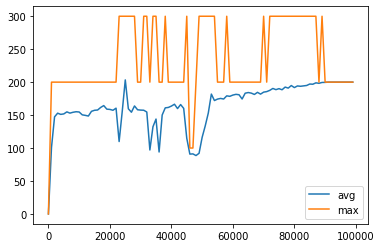

88
0 made it counter = 0 optimal counter = 0
10000 made it counter = 8832 optimal counter = 5
20000 made it counter = 17944 optimal counter = 9
30000 made it counter = 26915 optimal counter = 469
40000 made it counter = 36133 optimal counter = 489
50000 made it counter = 45449 optimal counter = 489
60000 made it counter = 54968 optimal counter = 489
70000 made it counter = 64625 optimal counter = 489
80000 made it counter = 74415 optimal counter = 489
90000 made it counter = 84349 optimal counter = 489


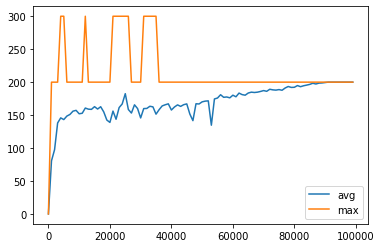

89
0 made it counter = 0 optimal counter = 0
10000 made it counter = 8923 optimal counter = 0
20000 made it counter = 17877 optimal counter = 0
30000 made it counter = 26829 optimal counter = 4
40000 made it counter = 35921 optimal counter = 86
50000 made it counter = 44711 optimal counter = 86
60000 made it counter = 53584 optimal counter = 86
70000 made it counter = 62856 optimal counter = 86
80000 made it counter = 72362 optimal counter = 86
90000 made it counter = 82193 optimal counter = 86


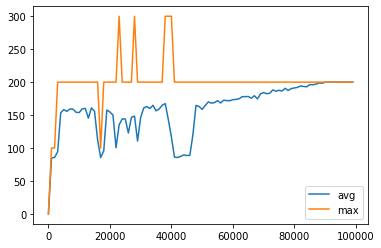

90
0 made it counter = 0 optimal counter = 0
10000 made it counter = 8617 optimal counter = 0
20000 made it counter = 17610 optimal counter = 0
30000 made it counter = 26692 optimal counter = 6
40000 made it counter = 35574 optimal counter = 15
50000 made it counter = 44905 optimal counter = 53
60000 made it counter = 54366 optimal counter = 72
70000 made it counter = 63820 optimal counter = 832


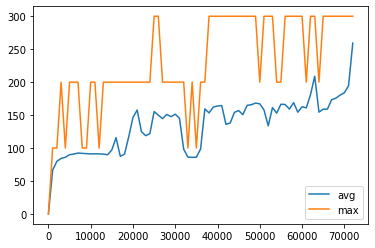

91
0 made it counter = 0 optimal counter = 0
10000 made it counter = 8724 optimal counter = 0
20000 made it counter = 17760 optimal counter = 3043
30000 made it counter = 26822 optimal counter = 6880
40000 made it counter = 35997 optimal counter = 9229
50000 made it counter = 45360 optimal counter = 11519
60000 made it counter = 54618 optimal counter = 13614


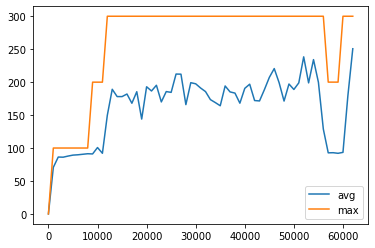

92
0 made it counter = 0 optimal counter = 0
10000 made it counter = 8837 optimal counter = 683
20000 made it counter = 17855 optimal counter = 806
30000 made it counter = 26879 optimal counter = 927
40000 made it counter = 36024 optimal counter = 972
50000 made it counter = 45359 optimal counter = 1330
60000 made it counter = 54850 optimal counter = 1387
70000 made it counter = 64512 optimal counter = 1670
80000 made it counter = 74291 optimal counter = 1696
90000 made it counter = 84225 optimal counter = 1708


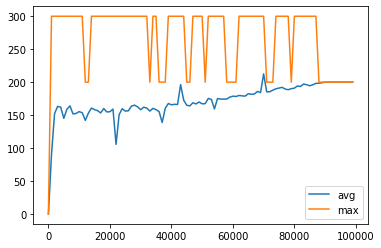

93
0 made it counter = 0 optimal counter = 0
10000 made it counter = 9000 optimal counter = 388
20000 made it counter = 18147 optimal counter = 667
30000 made it counter = 27268 optimal counter = 777
40000 made it counter = 36477 optimal counter = 909
50000 made it counter = 45793 optimal counter = 964
60000 made it counter = 55326 optimal counter = 2038
70000 made it counter = 64935 optimal counter = 4368


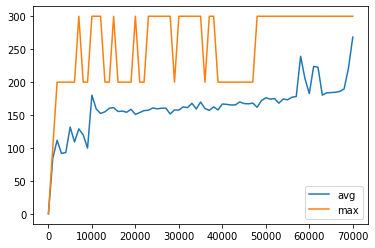

94
0 made it counter = 0 optimal counter = 0
10000 made it counter = 8387 optimal counter = 2018
20000 made it counter = 16583 optimal counter = 2572
30000 made it counter = 25433 optimal counter = 4340
40000 made it counter = 33578 optimal counter = 4382
50000 made it counter = 42186 optimal counter = 5384


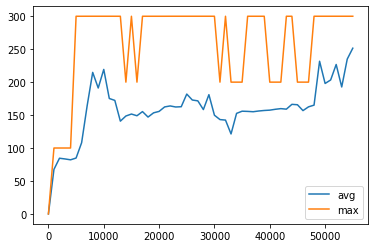

95
0 made it counter = 0 optimal counter = 0
10000 made it counter = 8005 optimal counter = 21
20000 made it counter = 16462 optimal counter = 3394
30000 made it counter = 24859 optimal counter = 6252
40000 made it counter = 33548 optimal counter = 9492
50000 made it counter = 42427 optimal counter = 15121


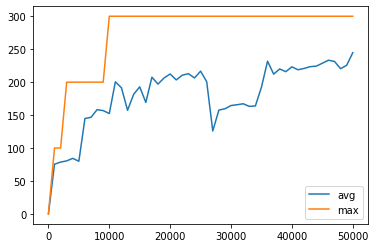

96
0 made it counter = 0 optimal counter = 0
10000 made it counter = 8811 optimal counter = 3
20000 made it counter = 17611 optimal counter = 205
30000 made it counter = 26232 optimal counter = 205
40000 made it counter = 35180 optimal counter = 205
50000 made it counter = 44332 optimal counter = 305
60000 made it counter = 53604 optimal counter = 692
70000 made it counter = 62897 optimal counter = 835
80000 made it counter = 72485 optimal counter = 840
90000 made it counter = 82422 optimal counter = 846


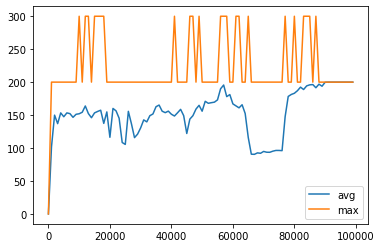

97
0 made it counter = 0 optimal counter = 0
10000 made it counter = 8601 optimal counter = 348
20000 made it counter = 17628 optimal counter = 5638
30000 made it counter = 26471 optimal counter = 7074
40000 made it counter = 35487 optimal counter = 11525
50000 made it counter = 44724 optimal counter = 16562
60000 made it counter = 54194 optimal counter = 17123


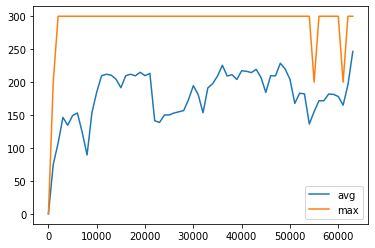

98
0 made it counter = 0 optimal counter = 0
10000 made it counter = 8595 optimal counter = 0
20000 made it counter = 16933 optimal counter = 539
30000 made it counter = 25569 optimal counter = 1112
40000 made it counter = 34554 optimal counter = 1759
50000 made it counter = 43200 optimal counter = 4147


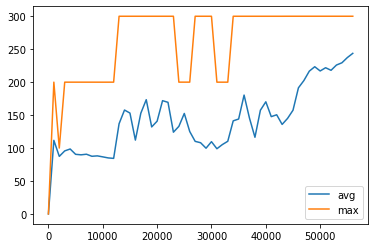

99
0 made it counter = 0 optimal counter = 0
10000 made it counter = 8332 optimal counter = 836
20000 made it counter = 17032 optimal counter = 1251
30000 made it counter = 25623 optimal counter = 6200
40000 made it counter = 34372 optimal counter = 10891
50000 made it counter = 43314 optimal counter = 14312
60000 made it counter = 52641 optimal counter = 18419


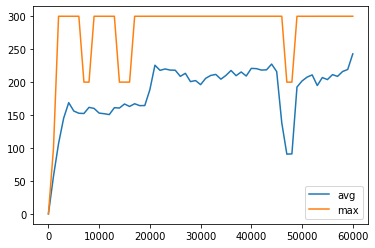

In [17]:
agents = []
for i in range(0,100):
    a = AgentQ(100000,0.075,0.05)
    print(i)
    a.train()
    a.plot()
    agents.append(a)




In [32]:
r2 = Room()
r2.visualizeMoveSeq(agents[73].aggr_ep_rewards['maxSeq'][5])